# train.py exps

In [1]:
import sys
import os
sys.path.append("/home/lauro/code/msc-thesis/svgd")
from importlib import reload

import jax.numpy as np
from jax import grad, jit, vmap, random, lax, jacfwd
from jax import lax
from jax.ops import index_update, index
import matplotlib.pyplot as plt
import numpy as onp
import jax
import haiku as hk

import utils
import metrics
import time
import plot
import stein
import train
import kernels

from jax.experimental import optimizers

rkey = random.PRNGKey(0)

/home/lauro/.virtualenvs/msc-thesis/lib/python3.6/site-packages/jax/lib/xla_bridge.py:119: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


# test thingy

In [2]:
from train import SVGD
from config import config

In [3]:
# config["svgd"]["optimizer_svgd"] = train.Optimizer(*optimizers.sgd(step_size=1))
# config["train_kernel"]["n_iter"] = 100
# config["svgd"]["kernel"] = hk.transform(kernels.vanilla_ard)

# config["train_kernel"]["opt_ksd"] = train.Optimizer(
#     *optimizers.adam(step_size=1e-2))


In [4]:
config["train_kernel"]["ksd_steps"] = 10
config["train_kernel"]["svgd_steps"] = 10
config["train_kernel"]["n_iter"] = 10

In [5]:
svgd = SVGD(**config["svgd"])

First, sample using random initialization of kernel parameters (logh initialized to 0).

In [6]:
key = config["train_kernel"]["key"]

In [7]:
dummies = svgd.target.sample((2,1))
init_params = svgd.kernel.init(key, *dummies)
comparison_samples, comparison_log = svgd.sample(init_params, **config["sample_args"])

100%|██████████| 100/100 [00:01<00:00, 55.44it/s]


Then, train kernel and sample using trained kernel parameters.

In [8]:
kernel_params, learn_log = svgd.train_kernel(**config["train_kernel"])

100%|██████████| 10/10 [05:33<00:00, 33.32s/it]


In [9]:
samples, sample_log = svgd.sample(kernel_params, **config["sample_args"])

100%|██████████| 100/100 [00:01<00:00, 77.15it/s]


## Analytics

### Comparison

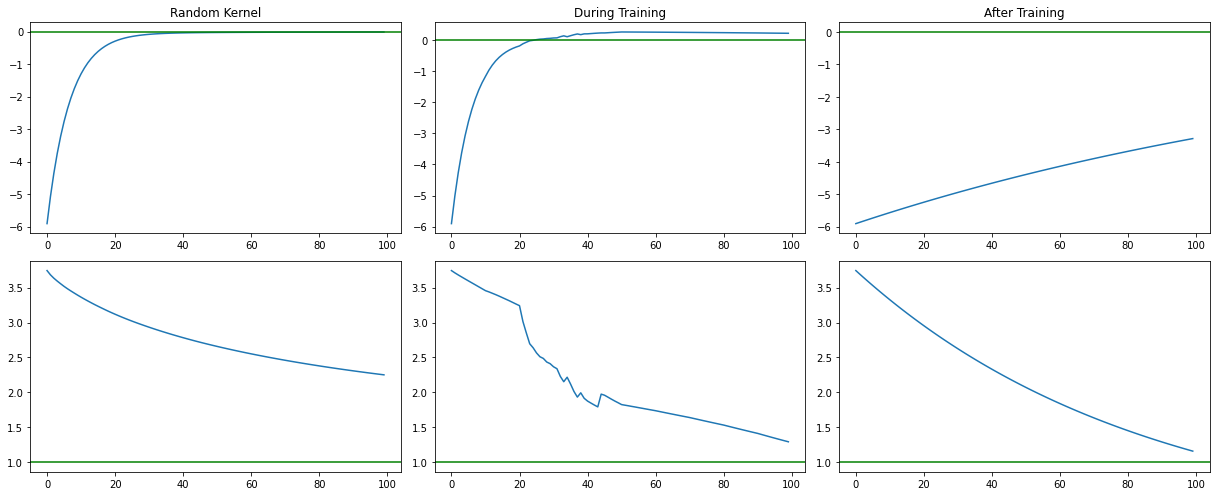

In [10]:
fig, axm = plt.subplots(2, 3, figsize=[17,7])

truths = (svgd.target.mean, svgd.target.cov.diagonal())
logs = comparison_log, learn_log, sample_log
titles = ["Random Kernel", "During Training", "After Training"]

for axs, l, title in zip(axm.transpose(), logs, titles):
    mean = l["mean"]
    var = l["var"]
    
    axs[0].set_title(title)
    for ax, data, tru in zip(axs, (mean, var), truths):
        ax.plot(data)
        ax.axhline(y=tru, color="green")
        
fig.tight_layout()

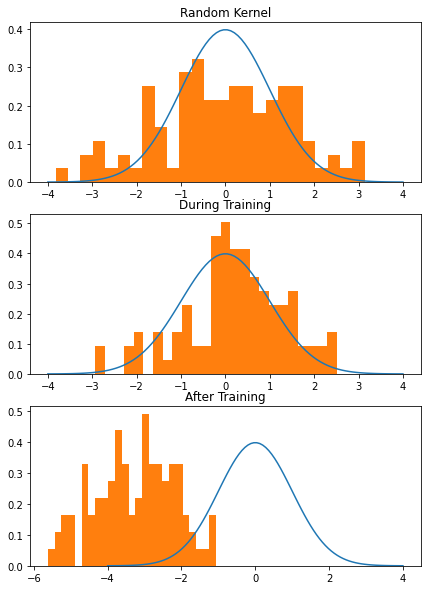

In [11]:
fig, axs = plt.subplots(3, figsize=[7, 10])
gr = np.linspace(-4, 4, 100)

for ax, samples, title in zip(axs, (comparison_samples, learn_log["particles"], samples), titles):
    ax.set_title(title)
    _ = ax.plot(gr, vmap(svgd.target.pdf)(gr))
    _ = ax.hist(samples[:, 0], bins=25, density=True)